# Train a BNN to classify MNIST using neural SVGD

In [1]:
# for leonhard
import os
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
os.environ['XLA_FLAGS']

'--xla_gpu_cuda_data_dir=/cluster/apps/gcc-6.3.0/cuda-10.1.243-n6qg6z5js3zfnhp2cfg5yjccej636czm'

In [33]:
# Train a Bayesian neural network to classify MNIST using
# Neural SVGD
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
%load_ext autoreload
import sys
import os
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/learning_particle_gradients/")
sys.path.append("../../experiments/")

import argparse
import matplotlib.pyplot as plt
from jax import vmap, random
import jax.numpy as jnp
import numpy as onp
from tqdm import tqdm
import optax
import bnn
import models
import metrics
import mnist
import config as cfg
import utils
from jax import jit, grad, value_and_grad

# Config
key = random.PRNGKey(0)
MAX_TRAIN_STEPS = 100  # df 100
META_LEARNING_RATE = 5e-3  # df 1e-3; should be as high as possible; regularize w/ max steps
PATIENCE = 5  # df 5; early stopping not v helpful, bc we overfit on all ps

NUM_SAMPLES = 100
DISABLE_PROGRESS_BAR = False
USE_PMAP = False

BATCH_SIZE = 128
LAMBDA_REG = 100
STEP_SIZE = 4e-5
PATIENCE = 15
MAX_TRAIN_STEPS = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# init particles and dynamics model

In [34]:
def init_particles_fn(subkey):
    init_particles = vmap(bnn.init_flat_params)(random.split(subkey, NUM_SAMPLES))
    return init_particles


key, subkey = random.split(key)
init_particles = init_particles_fn(subkey)
opt = optax.sgd(STEP_SIZE)

# opt = optax.chain(
#     optax.scale_by_adam(),
#     optax.scale(-STEP_SIZE),
# )

key, subkey1, subkey2 = random.split(key, 3)
neural_grad = models.SteinNetwork(target_dim=init_particles.shape[1],
                               learning_rate=META_LEARNING_RATE,
                               key=subkey1,
                               sizes= [256]*10 + [init_particles.shape[1]],
                               aux=False,
                               use_hutchinson=True,
                               lambda_reg=LAMBDA_REG,
                               patience=PATIENCE,
                               dropout=True,
                               normalize_inputs=True)

particles = models.Particles(subkey2, neural_grad.gradient, init_particles, custom_optimizer=opt)

minibatch_vdlogp = jit(vmap(grad(bnn.minibatch_logp), (0, None)))

init_particles.shape

(100, 4594)

In [35]:
# maximal initial stein discrepancy (theoretical ideal)
import plot
import stein
from jax.scipy import stats

n, d = init_particles.shape
n = 100
key, subkey = random.split(key)
xs = random.normal(subkey, (n, d)) / 100

first_batch = next(mnist.training_batches)
images, labels = first_batch

def logp(x):
    def loglikelihood(x):
        params = bnn.unravel(x)
        logits = bnn.model.apply(params, images)
        return -mnist.train_data_size/cfg.batch_size * bnn.crossentropy_loss(logits, labels)
    return loglikelihood(x) + bnn.log_prior(bnn.unravel(x))


def logq(x):
    return stats.norm.logpdf(x, loc=0, scale=1/100).sum()


def f(x):
    def loglikelihood(x):
        params = bnn.unravel(x)
        logits = bnn.model.apply(params, images)
        return -mnist.train_data_size/cfg.batch_size * bnn.crossentropy_loss(logits, labels) / (2*LAMBDA_REG)
    return grad(loglikelihood)(x)

# double-check stein discrepancy

# a) true
l2 = utils.l2_norm_squared(xs, f) # = sd(f*) / (2 LAMBDA_REG)
true_sd = 2 * LAMBDA_REG * l2
min_loss = -l2 * LAMBDA_REG

# b) hutchinson
key, subkey = random.split(key)
random_estimate_sd = stein.stein_discrepancy_hutchinson(subkey, xs, logp, f)

print("analytical sd:", true_sd)
print("hutchinson estimate:", random_estimate_sd)
print("ratio:", true_sd / random_estimate_sd)

analytical sd: 4559022.0
hutchinson estimate: 4564338.0
ratio: 0.9988353


# train to match true f directly, via squared error

In [36]:
@jit
def squared_error_loss(f_params, particles):
    """squared error, same scale as loss."""
    fnet = utils.negative(
            neural_grad.get_field(particles, f_params))
    return jnp.mean(vmap(
        lambda x: jnp.inner(fnet(x), fnet(x)) / 2 - jnp.inner(fnet(x), f(x)))(particles))



# @jit
# def squared_error_loss(f_params, particles):
#     """squared error, same scale as loss."""
#     fnet = utils.negative(
#             neural_grad.get_field(particles, f_params))
#     return jnp.mean(vmap(lambda x:
#                         (fnet(x)**2 / 2 - fnet(x) * f(x) + f(x)**2).sum())(particles))

adam = optax.adam(1e-4)
adam_state = adam.init(neural_grad.params)

@jit
def sel_step(xs, params, adam_state):
    loss, grads = value_and_grad(squared_error_loss)(params, xs)
    grads, adam_state = adam.update(grads, adam_state, params)
    params = optax.apply_updates(params, grads)
    return params, adam_state, {"loss": loss.mean()}


@jit
def l1_error(f_params, particles):
    fnet = utils.negative(
            neural_grad.get_field(particles, f_params))
    return vmap(lambda x: fnet(x) - grad(logp)(x))(particles).mean()

In [37]:
# rdata = {}
# min_sqe_params = neural_grad.params
# for _ in tqdm(range(300)):
#     key, subkey = random.split(key)
#     xs = init_particles_fn(subkey)
#     min_sqe_params, adam_state, aux = sel_step(xs, min_sqe_params, adam_state)
#     metrics.append_to_log(rdata, aux)

# plt.plot(rdata['loss'])

# v = utils.negative(neural_grad.get_field(xs, min_sqe_params))
# stein.stein_discrepancy_hutchinson(subkey, xs, logp, v)

# compare sampling and fixed

In [38]:
key, subkey = random.split(key)
split_particles = particles.next_batch(subkey, n_train_particles=75)
split_dlogp = [minibatch_vdlogp(x, first_batch)
               for x in split_particles]

In [39]:
# fixed
for _ in tqdm(range(300)):
    neural_grad.step(*split_particles, *split_dlogp)
    metrics.append_to_log(
        neural_grad.rundata,
        {
            "squared_error": squared_error_loss(
                neural_grad.params, split_particles[0]),
            "val_squared_error": squared_error_loss(
                neural_grad.params, split_particles[1]),
            "l1_error": l1_error(
                neural_grad.params, split_particles[0])
        }
    )

100%|██████████| 300/300 [00:16<00:00, 17.92it/s]


In [40]:
# sampling

# neural_grad_sampling = models.SteinNetwork(target_dim=init_particles.shape[1],
#                                        learning_rate=META_LEARNING_RATE,
#                                        key=subkey1,
#                                        sizes= [256]*10 + [init_particles.shape[1]],
#                                        aux=False,
#                                        use_hutchinson=True,
#                                        lambda_reg=LAMBDA_REG,
#                                        patience=PATIENCE,
#                                        dropout=False,
#                                        normalize_inputs=True)


# for _ in tqdm(range(300)):
#     key, subkey = random.split(key)
#     particles.particles = init_particles_fn(subkey)

#     key, subkey = random.split(key)
#     new_split_particles = particles.next_batch(subkey)
#     new_split_dlogp = [minibatch_vdlogp(x, first_batch)
#                        for x in new_split_particles]

#     neural_grad_sampling.step(*new_split_particles, *new_split_dlogp)

#### what's going on here??
why is the squared error so large? why doesn't it get smaller?

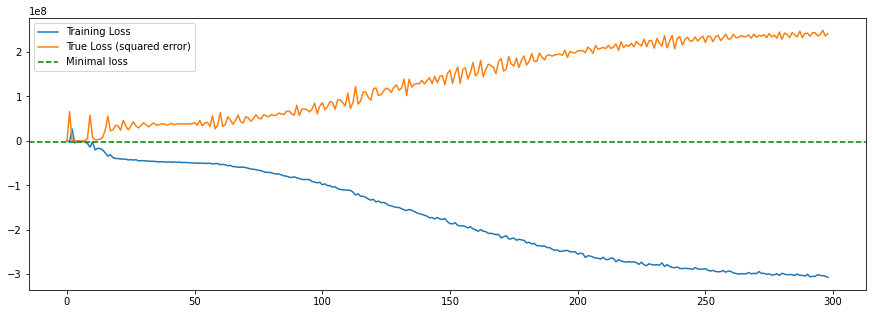

In [41]:
a = 0
b = -1
plt.subplots(figsize=[15, 5])
plt.plot(neural_grad.rundata['loss'][a:b], label="Training Loss")
# plt.plot(neural_grad.rundata['validation_loss'][a:b], label="Validation Loss")
plt.plot(neural_grad.rundata['squared_error'][a:b], label="True Loss (squared error)")
# plt.plot(neural_grad2.rundata['training_loss'][a:b], label="Sample new particles every iteration")

plt.axhline(y=min_loss, label="Minimal loss", linestyle="--", color="g")
plt.legend()